In [1]:
from scipy.stats import wilcoxon
import numpy as np

from pathlib import Path
import json

import pandas as pd
from matplotlib import pyplot as plt

In [2]:
_ = pd.read_csv("../resources/unimodality.txt", header=None, names=["modality"])
unimodalities = _.modality.values.tolist()

_ = pd.read_csv("../resources/multimodality.txt", header=None, names=["modality"], sep=";")
multimodalities = _.modality.values.tolist()

def alias(col_name):
    if "component_amplitudes" in col_name:
        if "100" in col_name:
            return "CA100"
        return "CA25"
    elif "partial_correlation" in col_name:
        if "100" in col_name:
            return "PC100"
        return "PC25"
    elif "full_correlation" in col_name:
        if "100" in col_name:
            return "FC100"
        return "FC25"
    elif "controlled" in col_name:
        return "C"
    elif "structure" in col_name:
        return "S"
    elif "diffusion" in col_name:
        return "D"
    else:
        raise ValueError(f"{col_name} no alias")

In [3]:
def load_aucs(artifact_dir, models, model_type="logistic", assert_same_random_seed_commit=True, sorting_factor=-1):
    headers =  [
        "rfMRI Partial Correlation 100 Features Related to", "auc:mean±std", "auc:min", "auc:max"
    ]
    
    print(f"Statistics from {artifact_dir}")

    
    commit = None
    random_seed = None
    rows = []
    n = None
    data = dict()
    for model in models:
        feature_set = model.replace(",", "-")
        artifact_path = f"{artifact_dir}/{model_type}--{feature_set}"
        if not Path(f"{artifact_path}/statistics.json").is_file():
            continue
                    
                    
        with open(f"{artifact_path}/statistics.json", "r") as fh:
            statistics = json.load(fh)
            aucs = np.array(statistics["aucs"]) 
    
            data[model] = aucs
        
        if assert_same_random_seed_commit:        
            with open(f"{artifact_path}/config.json", "r") as fh:
                model_config = json.load(fh)
                if commit is None:
                    commit = model_config["commit"]
                    random_seed = model_config["random_seed_value"]
                    n=aucs.shape[0]
                else:
                    assert commit == model_config["commit"]
                    assert random_seed == model_config["random_seed_value"]
                    assert n == aucs.shape[0]
    return data

In [4]:
main_model_dir = "../artifacts/2021-09-05-participants-withdraw-and-auroc"
ic_contribution_dir = main_model_dir

# main_model_dir = "../artifacts/2021-07-25-models-with-auprg-objective"
# ic_contribution_dir = "../artifacts/2021-07-29-ic-ranking-by-auprg"

# main_model_dir = "../artifacts/2021-06-26-paper-submission-logistic"
# ic_contribution_dir = "../artifacts/2021-07-24-ic-ranking-by-virtual-lesion"


ref_pc_100_model = "rfmri_partial_correlation_100"

all_models = unimodalities + multimodalities

In [5]:
def model_name_alias():
    aliases = []
    for model in all_models:
        slugs = map(lambda m: alias(m), model.split(","))
        aliases.append("+".join(slugs))
    return aliases
all_models_aliases = model_name_alias()

In [6]:
auc_main_models_pc_100_models = load_aucs(
    main_model_dir,
    all_models
)

Statistics from ../artifacts/2021-09-05-participants-withdraw-and-auroc


In [7]:
from matplotlib import colors

cmap = colors.ListedColormap(['white', '#660210'])

../artifacts/2021-09-05-participants-withdraw-and-auroc


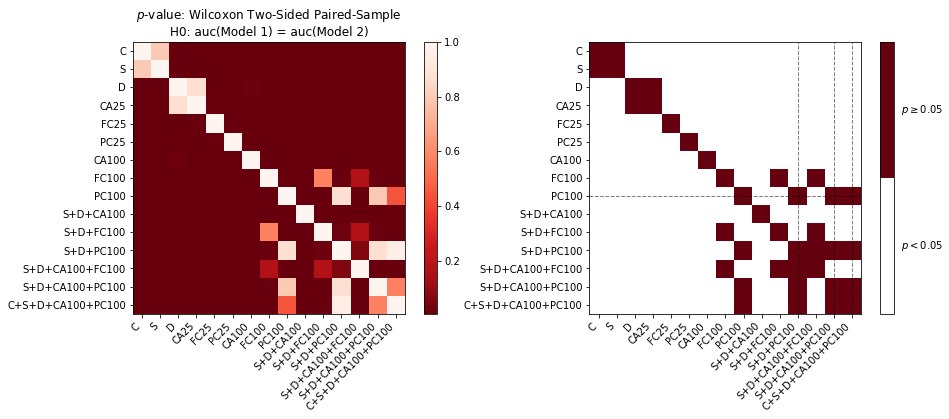

In [8]:
def ht_pairwise_models():
    print(main_model_dir)
    total_models = len(all_models)
    
    pvalues = np.ones((total_models, total_models))
    
    for ix in range(total_models):
        aucs1 = auc_main_models_pc_100_models[all_models[ix]]
        for jx in range(ix+1, total_models):
            aucs2 = auc_main_models_pc_100_models[all_models[jx]]

            st, p = wilcoxon(aucs1, aucs2)
            pvalues[jx, ix] = p
            pvalues[ix, jx] = p

    plt.figure(figsize=(7.5*2, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(pvalues, cmap="Reds_r")
    plt.colorbar()
    plt.title("$p$-value: Wilcoxon Two-Sided Paired-Sample\nH0: auc(Model 1) = auc(Model 2)")
    plt.yticks(range(total_models), all_models_aliases)
    plt.xticks(range(total_models), all_models_aliases, rotation=45, ha="right")
    
    plt.subplot(1, 2, 2)
    plt.imshow((pvalues >= 0.05).astype(float), cmap=cmap)
    plt.xticks(range(total_models), all_models_aliases, rotation=45, ha="right")
    plt.yticks(range(total_models), all_models_aliases)
    
    cbar = plt.colorbar()
    plt.axhline(np.argwhere(np.array(all_models_aliases) == "PC100"), color="k", ls="--", lw="1", alpha=0.5)
    cbar.ax.get_yaxis().set_ticks([])
    for j, lab in enumerate(['$p < 0.05$', r"$p \geq 0.05$"]):
        cbar.ax.text(1.5,  (j + 0.5)/ 2, lab, ha='left', va='center')
        
    for ix, al in enumerate(all_models_aliases):
        if "+PC100" in al:
            plt.axvline(ix, color="k", ls="--", lw="1", alpha=0.5)

ht_pairwise_models()

In [9]:
_ = pd.read_csv("./resources/rfmri_not_ics_partial_correlation_100.txt", header=None, names=["model"], sep=";")
not_ic_models = _.model.values.tolist()

In [10]:
auc_ic_models = load_aucs(
    ic_contribution_dir,
    not_ic_models
)
auc_ic_models;

Statistics from ../artifacts/2021-09-05-participants-withdraw-and-auroc


main-model-dir: ../artifacts/2021-09-05-participants-withdraw-and-auroc
ic-model-dir: ../artifacts/2021-09-05-participants-withdraw-and-auroc


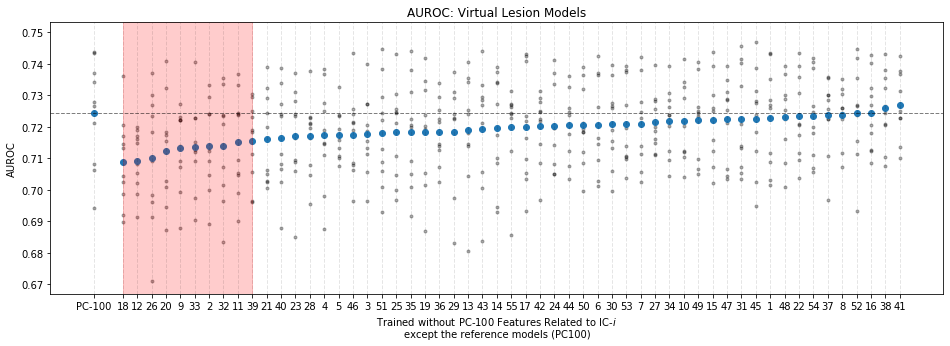

In [62]:
def ic_contribution():
    print(f"main-model-dir: {main_model_dir}")
    print(f"ic-model-dir: {ic_contribution_dir}")
    
#     ic_keys = list(map(lambda i: f"rfmri_not_ic{i}_partial_correlation_100", range(1, 55 + 1)))
    
    

    
    
    aucs_virtual_lesion_ic_models = np.zeros((55, 10))
    # our index start at 1
    for ix in range(1, 55+1):
        aucs_virtual_lesion_ic_models[ix-1, :] = auc_ic_models[f"rfmri_not_ic{ix}_partial_correlation_100"]
        
    aucs = np.zeros((1+55, 10))

    mean_aus = np.mean(aucs_virtual_lesion_ic_models, axis=1)
    
    # remember that ic_index start at 1
    ic_indexes = np.argsort(mean_aus) + 1
    
    assert np.sum(ic_indexes == 0) == 0 and np.max(ic_indexes) == 55, "make sure we get the IC index right"
    
    aucs[0, :] = auc_main_models_pc_100_models[ref_pc_100_model]
    
    for ix, ic_ix in enumerate(ic_indexes):
        aucs[ix+1, :] = auc_ic_models[f"rfmri_not_ic{ic_ix}_partial_correlation_100"]

    
    colunm_indices = [-1] + list(range(1, 56))
    
    plt.figure(figsize=(16, 5))
    plt.axvspan(1, 10, color="red", alpha=0.2)
    
    plt.title("AUROC: Virtual Lesion Models")
    for ix, cix in enumerate(colunm_indices):
        plt.scatter([cix]*10, aucs[ix, ], color="k", marker=".", alpha=0.3)
        plt.axvline(cix, alpha=0.1, color="k", lw=1, ls="--")
        
    plt.scatter(colunm_indices, np.mean(aucs, axis=1))
    

    
    plt.axhline(
        np.mean(auc_main_models_pc_100_models[ref_pc_100_model]),
        ls="--", alpha=0.5, lw="1", color="k"
    )
    plt.xticks(colunm_indices, ["PC-100"] + ic_indexes.tolist())
    plt.ylabel("AUROC")
    
    
    plt.xlabel("Trained without PC-100 Features Related to IC-$i$\nexcept the reference models (PC-100)")

ic_contribution()